In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('data.csv')

In [2]:
from sklearn import metrics
def print_metrics(pred, y_vals):
    print('mape: ', metrics.mean_absolute_percentage_error(y_vals, pred))
    print('mae: ', metrics.mean_absolute_error(y_vals, pred))
    print('mse: ', metrics.mean_squared_error(y_vals, pred))
    print('rmse: ', np.sqrt(metrics.mean_squared_error(y_vals, pred)))
    print('r2: ', metrics.r2_score(y_vals, pred))
    count = 0
    y_error = pred.flatten() - y_vals.flatten()
    y_error = np.array([abs(e) for e in y_error]).flatten()
    for i in range(len(y_error)):
        if(y_error[i] < 0.25 * y_vals[i]):
            count += 1
    print('25% 准确度: ', count / len(pred))

In [3]:
from prophet import Prophet
import os
split_line=5800
filename='prophet_all_ceemdan.npy'
if os.path.isfile(filename):
    X=np.load(filename)
else:
    X=np.empty((data.shape[0],0))
    for name in ["lrad", "prec", "pres", "shum", "srad", "temp", "wind"]:
        all_iceemdan = pd.read_csv(name + '.csv')
        features = ['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms',
                    'additive_terms_lower', 'additive_terms_upper', 'daily', 'daily_lower', 'daily_upper',
                    'yearly', 'yearly_lower', 'yearly_upper', 'yhat']
        for index in all_iceemdan.columns:
            if index == 'ds':
                continue
            temp_df = pd.DataFrame(all_iceemdan['ds'][:split_line])
            temp_df['y'] = all_iceemdan[index][:split_line]
            m = Prophet(changepoint_prior_scale=1.0, seasonality_prior_scale=0.1, seasonality_mode='additive', changepoint_range=1, yearly_seasonality=True)
            m.fit(temp_df)
            future = m.make_future_dataframe(periods=len(all_iceemdan['ds'])-split_line, freq='3H')
            forecast = m.predict(future)
            X=np.append(X, forecast[features].to_numpy(), axis=1)
    np.save(filename, X)

In [4]:
X.shape

(5840, 1290)

In [5]:
X_train = np.array(X[:split_line])
X_test = np.array(X[split_line:])
y = data[["wind"]][1:]
y_train = np.array(y[:split_line])
y_test = np.array(y[split_line:])

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
from sklearn.decomposition import KernelPCA
pca = KernelPCA(kernel='rbf')
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [7]:
X_train.shape

(5800, 5799)

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 1024)           20966400  
                                                                 
 gru_1 (GRU)                 (None, 1, 512)            2362368   
                                                                 
 dense (Dense)               (None, 1, 1)              513       
                                                                 
Total params: 23,329,281
Trainable params: 23,329,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
180/180 [==============================] - 205s 1s/step - loss: 1.3492 - val_loss: 1.4177
Epoch 2/100
180/180 [==============================] - 178s 987ms/step - loss: 0.8832 - val_loss: 1.3174
Epoch 3/100
180/180 [==============================] - 178s 987ms/step - loss: 0.5831 - val_loss: 1.4

Epoch 71/100
180/180 [==============================] - 217s 1s/step - loss: 0.0139 - val_loss: 1.4719
Epoch 72/100
180/180 [==============================] - 215s 1s/step - loss: 0.0139 - val_loss: 1.4481
Epoch 73/100
180/180 [==============================] - 217s 1s/step - loss: 0.0137 - val_loss: 1.4422
Epoch 74/100
180/180 [==============================] - 216s 1s/step - loss: 0.0138 - val_loss: 1.4613
Epoch 75/100
180/180 [==============================] - 210s 1s/step - loss: 0.0137 - val_loss: 1.4629
Epoch 76/100
180/180 [==============================] - 200s 1s/step - loss: 0.0137 - val_loss: 1.4674
Epoch 77/100
180/180 [==============================] - 206s 1s/step - loss: 0.0140 - val_loss: 1.4144
Epoch 78/100
180/180 [==============================] - 199s 1s/step - loss: 0.0142 - val_loss: 1.4543
Epoch 79/100
180/180 [==============================] - 198s 1s/step - loss: 0.0143 - val_loss: 1.4793
Epoch 80/100
180/180 [==============================] - 210s 1s/step - lo

<IPython.core.display.Javascript object>


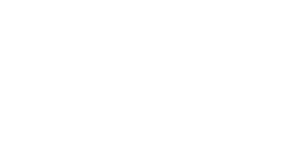

INFO:tensorflow:Assets written to: all_prophet_gru\assets


INFO:tensorflow:Assets written to: all_prophet_gru\assets


In [9]:
from tensorflow import keras
modelname='all_prophet_gru'
if os.path.isdir(modelname):
    model = keras.models.load(modelname)
else:
    model = keras.models.Sequential()
    model.add(keras.layers.GRU(1024,input_shape = (1, X_train.shape[2]),return_sequences = True))
    model.add(keras.layers.GRU(512,activation = 'gelu', recurrent_activation = 'gelu',return_sequences = True))
    model.add(keras.layers.Dense(1))
    es_callback = keras.callbacks.EarlyStopping(patience = 50, restore_best_weights = True, monitor="loss")
    model.compile(loss = keras.losses.Huber(), optimizer = keras.optimizers.Nadam())
    model.summary()
    keras.utils.plot_model(model, to_file=modelname+'model_plot.pdf', show_shapes=True, show_layer_names=True)
    history=model.fit(X_train, y_train, validation_split = 0.01, epochs = 100, verbose = 1,
                      shuffle = True, callbacks = [es_callback])
    import matplotlib.pyplot as plt
    %matplotlib notebook
    plt.rcParams['font.size']=64
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    pic = plt.figure(figsize=(32,32))
    plt.plot(history.history['loss'])
    plt.title(u'多特征ICEEDMAN-Prophet-GRU模型训练损失变化')
    plt.xlabel(u'Epoch')
    plt.ylabel(u'损失')
    pic.savefig(modelname + "_training_loss.pdf")
    model.save(modelname)

In [10]:
predicted = model.predict(X_train).flatten()
predicted[predicted < 0] = 0
predictions = model.predict(X_test).flatten()
predictions[predictions < 0] = 0

In [11]:
print_metrics(predicted, y_train)

mape:  0.04486806982673257
mae:  0.12356680479810452
mse:  0.07946772036320189
rmse:  0.2819001957487825
r2:  0.9856359527616432
25% 准确度:  0.9853448275862069


In [12]:
print_metrics(predictions[:-1], y_test)

mape:  2.695117406473259
mae:  2.722846345882271
mse:  9.966235226039085
rmse:  3.156934466541725
r2:  -0.03660259000417909
25% 准确度:  0.15384615384615385


In [13]:
generated = pd.DataFrame(data['ds'])[:-1]
generated['y_pred'] = np.append(predicted, predictions)[:-1]
generated['y_real'] = np.array(y)
generated.to_csv(modelname + ".csv")

<IPython.core.display.Javascript object>


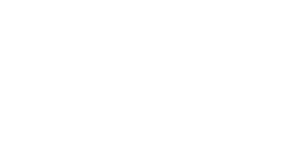

In [14]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['font.size']=64
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

fore_line=4100
end_line=4200
pic = plt.figure(figsize=(32,32))
plt.plot(y_train[fore_line:end_line],'g',predicted[fore_line:end_line],'r')
plt.title('多特征ICEEDMAN-Prophet-GRU模型训练集拟合')
plt.plot(y_train[fore_line:end_line],'g',label=u'真实值')
plt.plot(predicted[fore_line:end_line],'r',label=u'预测值')
plt.xlabel(u'时间（3小时）')
plt.ylabel(u'近地面全风速（m/s）')
plt.legend()
pic.savefig(modelname + "_predict_train.pdf")

<IPython.core.display.Javascript object>


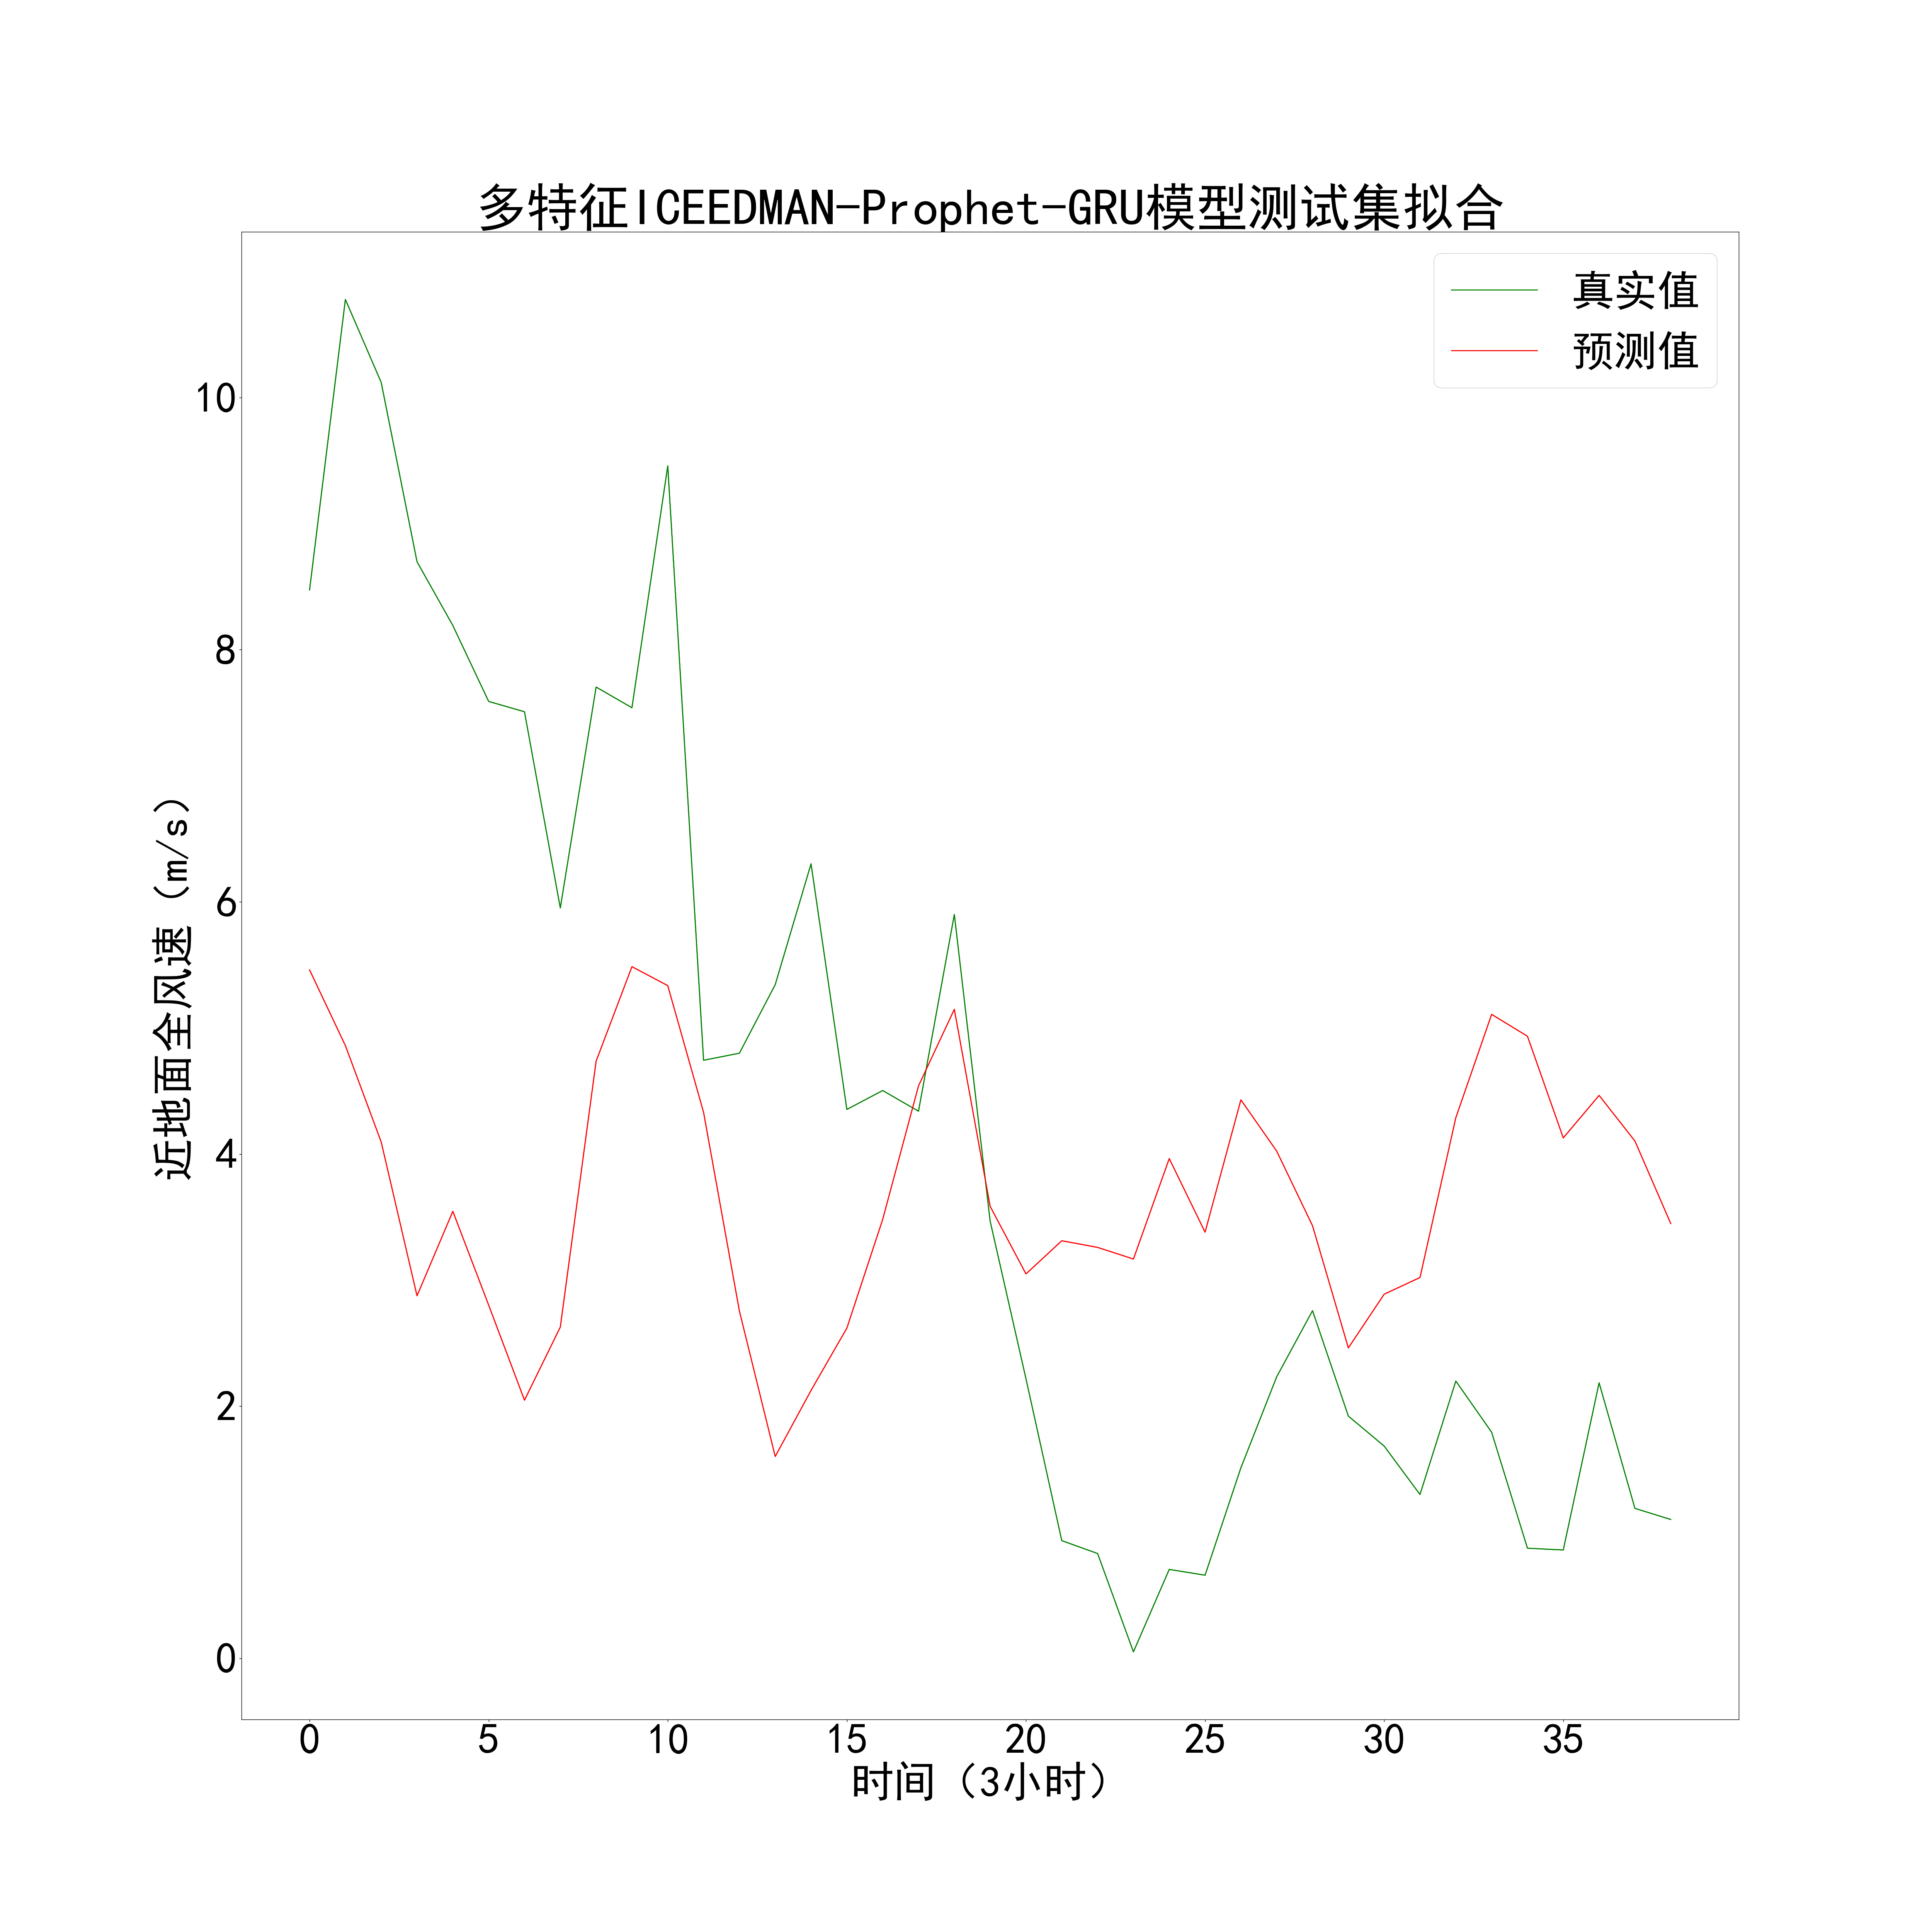

In [15]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['font.size']=64
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

pic = plt.figure(figsize=(32,32))
plt.plot(y_test,'g',predictions[:-1],'r')
plt.title('多特征ICEEDMAN-Prophet-GRU模型测试集拟合')
plt.plot(y_test,'g',label=u'真实值')
plt.plot(predictions[:-1],'r',label=u'预测值')
plt.xlabel(u'时间（3小时）')
plt.ylabel(u'近地面全风速（m/s）')
plt.legend()
pic.savefig(modelname + "_predict_test.pdf")